In [1]:
import torch
import torch.nn as nn
from torch.nn.modules.utils import _pair
import torch.nn.functional as F
from torchvision import models, transforms

from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection

from torch.cuda.amp import GradScaler, autocast

from tqdm.notebook import tqdm

# garbage collector
import gc

import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device -> {device}')

device -> cpu


# Utils

Ниже приведены вспомогательные методы для визуализации данных.

In [2]:
def colored_depthmap(depth, d_min = None, d_max = None, cmap = plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

class UnNormalize(transforms.Normalize):

    def __init__(self, is_depth=False, *args, **kwargs):
        if is_depth:
            mean = (0.485, )
            std = (0.229, )
        else:
            mean = (0.485, 0.456, 0.406)
            std = (0.229, 0.224, 0.225)
        new_mean = [-m/s for m, s in zip(mean, std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, targets, preds = None, n = 4, figsize = (6, 2), title = ''):
    '''
    plot_vals method is designed to visualize the operation of the model

    Parameters:
        imgs(torch.Tensor) - rgb images

        preds(torch.Tensor) - predictions of the model

        targets(torch.Tensor) - ground truth values of the target

        n(int) - number of visualizations

        figsize(turple) - size of he figure

        title(str) - general description for visualization
    '''

    plt.figure(figsize=figsize, dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i, idx in enumerate(np.random.randint(0, imgs.size(0), (n,))):
        ax = plt.subplot(r, c, i + 1)

        if preds is not None:
            img, pred, gt = imgs[idx, :3], preds[idx], targets[idx]
        else:
            img, gt = imgs[idx, :3], targets[idx]

        img = UnNormalize()(img)*255.
        gt = UnNormalize(is_depth=True)(gt)*255.

        img, gt = img.permute(1, 2, 0).numpy(), gt.permute(1, 2, 0).numpy()
        gt = colored_depthmap(np.squeeze(gt))

        image_viz = np.hstack([img, gt])
        if preds is not None:
            pred = UnNormalize(is_depth=True)(pred)*255.
            pred = pred.permute(1, 2, 0).numpy()
            pred = colored_depthmap(np.squeeze(pred))
            image_viz = np.hstack([img, gt, pred])

        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")

    if preds is not None:
        base_title = 'image/target/prediction'
    else:
        base_title = 'image/target'

    title = f'{title}\nimage/target/prediction' if len(title) != 0 else base_title
    plt.suptitle(title)
    plt.show()

# Data

У нас всего около 50000+ сэмплов обучающих данных. Нам необходимо добавить 4 канал к каждому изображению. Чтобы не генерировать разряженные маски глубины в самом методе __getitem__, сгененрируем заранее 1000 сэмплов маски, а затем будем обращаться к ним по следующему принципу:

mask = masks[index % 1000]

In [3]:
"""
As the fourth channel, we add a sparse depth map to the rgb image. The sparsity
of the depth map is regulated by the alpha parameter (float, [0...1])
"""

alpha = 0.1  # 10%
masks = (torch.rand(1000, 1,  224, 224) < alpha).float()

In [4]:
import os

class NYUDepthV2Dataset(torch.utils.data.Dataset):
    r"""
    Class NYUDepthV2Dataset designed to work with dataset NYUDepth-V2:
    https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

    Attributes:
        transform(dict) - composition of methods for data preprocessing (keys=['rgb', 'depth'])

        root(str) - path to root directory (nyu_data)

        train(bool) - if True: return train dataset, elsewhere test dataset

        data(pd.DataFrame) - DataFrame, which contains the corresponding paths
                             to rgb images and depth maps
    """

    BASEMENT_CSV = {True: 'data/nyu2_train.csv',
                    False: 'data/nyu2_test.csv'}

    def __init__(self, root, train=True, transform=None):
        super(NYUDepthV2Dataset, self).__init__()
        self.transform = transform
        self.data = pd.read_csv(root + '/' + self.BASEMENT_CSV[train],
                                header=None, names=['rgb', 'depth'])
        self.root = root

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        rgb_path = os.path.join(self.root, self.data.loc[index, 'rgb'])
        depth_path = os.path.join(self.root, self.data.loc[index, 'depth'])

        rgb = Image.open(rgb_path).convert('RGB')
        depth = Image.open(depth_path)

        if self.transform:
            rgb = self.transform['rgb'](rgb)
            depth = self.transform['depth'](depth)

        mask = masks[index % 1000]
        sparse_depth = depth * mask
        rgb = torch.cat((rgb, sparse_depth), dim=0)

        return rgb, depth

В приведенном ниже блоке кода создаются:
* словарь transform, который содержит соответсвующие преобразования для rgb и depth картинок;
* train, validation и test датасеты;
* соответсвующие им объекты класса DataLoader.

In [5]:
root_path = 'nyu_data'

rgb_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

depth_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.485, std=0.229)
])


transform = {
    'rgb': rgb_transform,
    'depth': depth_transform
}


train_dataset = NYUDepthV2Dataset(root=root_path,
                                  train=True,
                                  transform=transform)

# train-validation-test split
k = 0.9
train_size = int(len(train_dataset) * k)
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
                                                           [train_size, val_size])

val_size = int(len(val_dataset) * k)
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [val_size, test_size])

# dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

## Визуализация

Визуализируем несколько сэмплов данных.

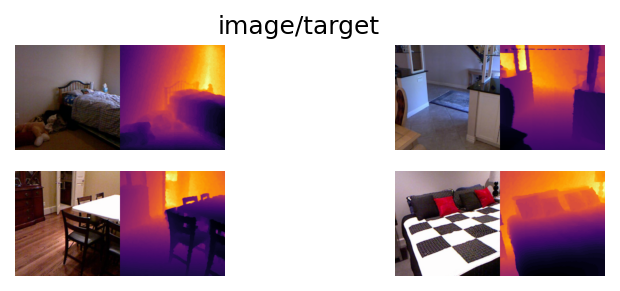

In [6]:
for batch in train_loader:
    rgbd, depth = batch
    break

plot_vals(
    rgbd,
    depth,
    n = 4
)

# Model

## Encoder

In [7]:
class Encoder(torch.nn.Module):

    def __init__(self, resnet):
        super(Encoder, self).__init__()
        self.resnet = resnet
        self.conv1x1 = nn.Conv2d(2048, 1024, 1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(1024)

        self.conv1x1.weight.requires_grad = True
        self.bn.weight.requires_grad = True

        self.relu = nn.ReLU()

    def forward(self, input):
        out = self.relu(self.resnet(input))
        out = self.relu(self.conv1x1(out))
        return self.bn(out)

## Decoder

In [8]:
class Decoder(torch.nn.Module):

    def __init__(self, adnn):
        super(Decoder, self).__init__()
        self.adnn = adnn
        self.bn1 = nn.BatchNorm2d(256)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv = nn.Conv2d(64, 1, 3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(1)
        self.biup = nn.Upsample((224, 224), mode='bilinear')
        self.relu = nn.ReLU()
        self.bnexit = nn.BatchNorm2d(1)

    def forward(self, input):
        out = adnn(input)
        out = self.bn1(out)
        out = self.relu(self.deconv1(out))
        out = self.bn2(out)
        out = self.relu(self.deconv2(out))
        out = self.bn3(out)
        out = self.relu(self.conv(out))
        out = self.bn4(out)
        out = self.biup(out)
        return self.bnexit(out)

## ADNN Layers

In [9]:
class ADNNConv2d(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, rho=0.5, activation=None, activation_params=None):
        super(ADNNConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _pair(padding)

        self.rho = float(rho)
        act_params = {} if activation_params is None else activation_params
        self.activation = activation(*act_params)

        self.weight = nn.Parameter(torch.Tensor(self.out_channels,
                                                self.in_channels,
                                                *self.kernel_size),
                                   requires_grad=True)
        nn.init.kaiming_uniform_(self.weight, nonlinearity='relu')

        self.lambdas = None

    def _operator(self, input, weight):
        return F.conv2d(input, weight, None, self.stride, self.padding)

    def _inverse_operator(self, input, weight):
        return F.conv_transpose2d(input, weight, None, self.stride, self.padding)

    def _adnn_step(self, preact, act, prevact, oldact):
        # dual updating
        self.lambdas = self.lambdas + self.rho * (preact - act) # t-step

        # preactivation updating
        z_waved = act - 1 / self.rho * self.lambdas # t-step
        preact_new = z_waved + 1 / (self.rho + 1) * self._operator(
            prevact - self._inverse_operator(z_waved, self.weight),
            self.weight
        ) # t+1-step

        act_new = preact_new + 1 / self.rho * self.lambdas # t+1-step
        if oldact is not None:
            act_new = 1 / (self.rho + 1) * (oldact + self.rho * act_new)
        act_new = self.activation(act_new)

        return preact_new, act_new

    def forward(self, input, preact=None, act=None, prevact=None, step=0, oldact=None):
        if step == 0:
            preact = self._operator(input, self.weight)
            act = self.activation(preact)
        else:
            if step == 1:
                self.lambdas = torch.zeros(act.size(), device=act.device)

            preact, act = self._adnn_step(preact, act, prevact, oldact)

        return preact, act

class ADNNConvTranspose2d(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, output_padding=0, rho=0.5, activation=None, activation_params=None):
        super(ADNNConvTranspose2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _pair(padding)
        self.output_padding = output_padding

        self.rho = float(rho)
        act_params = {} if activation_params is None else activation_params
        self.activation = activation(*act_params)

        self.weight = nn.Parameter(torch.Tensor(self.in_channels,
                                                self.out_channels,
                                                *self.kernel_size),
                                   requires_grad=True)
        nn.init.kaiming_uniform_(self.weight, nonlinearity='relu')

        self.lambdas = None

    def _operator(self, input, weight):
        return F.conv_transpose2d(input, weight, None, self.stride, 
                                  self.padding, self.output_padding)

    def _inverse_operator(self, input, weight):
        return F.conv2d(input, weight, None, self.stride, self.padding)

    def _adnn_step(self, preact, act, prevact, oldact):
        # dual updating
        self.lambdas = self.lambdas + self.rho * (preact - act) # t-step

        # preactivation updating
        z_waved = act - 1 / self.rho * self.lambdas # t-step
        preact_new = z_waved + 1 / (self.rho + 1) * self._operator(
            prevact - self._inverse_operator(z_waved, self.weight),
            self.weight
        ) # t+1-step

        act_new = preact_new + 1 / self.rho * self.lambdas # t+1-step
        if oldact is not None:
            act_new = 1 / (self.rho + 1) * (oldact + self.rho * act_new)
        act_new = self.activation(act_new)

        return preact_new, act_new

    def forward(self, input, preact=None, act=None, prevact=None, step=0, oldact=None):
        if step == 0:
            preact = self._operator(input, self.weight)
            act = self.activation(preact)
        else:
            if step == 1:
                self.lambdas = torch.zeros(act.size(), device=act.device)

            preact, act = self._adnn_step(preact, act, prevact, oldact)

        return preact, act

class ADNN(torch.nn.Module):

    def __init__(self, layers, T=1):
        super(ADNN, self).__init__()
        self.layers = layers
        self.T = T
        self.feedforward = False

    def forward(self, x):
        storage = [{} for layer in self.layers]

        for t in range(self.T):
            for j in range(len(self.layers)):
                input = x if (j == 0) and (t == 0) else storage[j - (t==0)]['act']
                preact = x if (j == 0) and (t == 0) else storage[j - (t==0)]['preact']
                prevact = x if j==0 or t==0 else storage[j - 1]['act']
                act = input
                if preact is None:
                    preact = input

                oldact = None
                if (t != 0) and (j < len(self.layers) - 1):
                    oldact = self.layers[j+1]._inverse_operator(storage[j+1]['preact'],
                                                               self.layers[j+1].weight)

                storage[j]['preact'], storage[j]['act'] = self.layers[j](input, preact, act,
                                                                        prevact, t, oldact)
        output = storage[-1]['act'].clone()
        del storage
        return output

## Model creation

### Модификация resnet50

Для создания энкодера, мы используем модель resnet50. Согласно модели приведенной ниже, нам необходимо сделать так, чтобы на вход модель принимала картинки с 4 каналами - RGBD (Red, Green, Blue, sparse Depth). Для этого мы переопределяем слой __conv1__, веса для RGB мы берем из сохраненных заранее весов уже натренированной модели, в качетсве весов для слоя D скопируем веса R. Соответсвенно, в классе для работы с Dataset'ом в методе getitem происходит добавление 4 канала, для которого нормализация соответсвует необходимой нормализации для модели resnet50 (depth предобрабатывается аналогично красному каналу RGB изображения).

__Замечание__: энкодер состоит из последовательности resnet50_modified, точечной свертки cov1x1 и слоя BatchNorm2d на выходе. В качестве функции активации используется ReLU. Также из модели resnet50 мы __удаляем__ последние два слоя: AvgPooling и Fully Connected.

![](https://raw.github.com/egorio-gg/DeepCA_NYUDepthV2/ed344416b0d13dff46c63e49f9b27edc84a9f6c7/architecture_1.jpg)

Рис1. Архитектура нейросети из [статьи](https://arxiv.org/abs/1709.07492), на которую ссылается наша основная статья DeepCA via ADNN.

![](https://raw.github.com/egorio-gg/DeepCA_NYUDepthV2/ed344416b0d13dff46c63e49f9b27edc84a9f6c7/architecture_2.jpg)

Рис2. Архитектура из статьи [DeepCA via ADNN](https://openaccess.thecvf.com/content_ECCV_2018/html/Calvin_Murdock_Deep_Component_Analysis_ECCV_2018_paper.html).

In [10]:
resnet_model = models.resnet50(pretrained=True)
weight = resnet_model.conv1.weight.clone()
resnet_model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

with torch.no_grad():
    resnet_model.conv1.weight[:, :3] = weight
    resnet_model.conv1.weight[:, 3] = weight[:, 0]

layers = OrderedDict()
for name, layer in resnet_model.named_children():
    if name not in ['avgpool', 'fc']:
        layers[name] = layer

resnet_model = nn.Sequential(layers)

'''
Проверка размерности инференса, полученного из resnet_model
'''
x = torch.randn(10, 4, 224, 224)
output = resnet_model(x)
output.shape

torch.Size([10, 2048, 7, 7])

Мы загрузили уже предобученную модель, заморозим все ее веса, чтобы они не обновлялись в процссе обучения.

In [11]:
for param in resnet_model.parameters():
    param.requires_grad = False

for name, param in resnet_model.named_parameters():
    if param.requires_grad:
        print(f'{name} is trainable')
    else:
        print(f'{name} is frozen')

conv1.weight is frozen
bn1.weight is frozen
bn1.bias is frozen
layer1.0.conv1.weight is frozen
layer1.0.bn1.weight is frozen
layer1.0.bn1.bias is frozen
layer1.0.conv2.weight is frozen
layer1.0.bn2.weight is frozen
layer1.0.bn2.bias is frozen
layer1.0.conv3.weight is frozen
layer1.0.bn3.weight is frozen
layer1.0.bn3.bias is frozen
layer1.0.downsample.0.weight is frozen
layer1.0.downsample.1.weight is frozen
layer1.0.downsample.1.bias is frozen
layer1.1.conv1.weight is frozen
layer1.1.bn1.weight is frozen
layer1.1.bn1.bias is frozen
layer1.1.conv2.weight is frozen
layer1.1.bn2.weight is frozen
layer1.1.bn2.bias is frozen
layer1.1.conv3.weight is frozen
layer1.1.bn3.weight is frozen
layer1.1.bn3.bias is frozen
layer1.2.conv1.weight is frozen
layer1.2.bn1.weight is frozen
layer1.2.bn1.bias is frozen
layer1.2.conv2.weight is frozen
layer1.2.bn2.weight is frozen
layer1.2.bn2.bias is frozen
layer1.2.conv3.weight is frozen
layer1.2.bn3.weight is frozen
layer1.2.bn3.bias is frozen
layer2.0.con

### Инициализация ADNN блока

ADNN блок сети состоит из двух слоев UpSampling, который реализуется с помощью деконволюции. Деконволюция в ADNN блоке представлена слоями ADNNConvTranspose2d, введенными выше. В качестве функции активации в ADNN слоях используем LeakyReLU.

In [12]:
adnn_layers = nn.Sequential(
    ADNNConvTranspose2d(1024, 512, 4, stride=2, padding=1, activation=nn.LeakyReLU),
    ADNNConvTranspose2d(512, 256, 4, stride=2, padding=1, activation=nn.LeakyReLU)
)

for name, layer in adnn_layers.named_parameters():
    print(f'{name} -> {param.requires_grad}')

adnn = ADNN(adnn_layers, T=1)

'''
Проверка размерности инференса, полученного с помощью adnn
'''
data = torch.randn(10, 1024, 7, 7)
adnn(data).shape

0.weight -> False
1.weight -> False


torch.Size([10, 256, 28, 28])

### Depthnet (autoencoder)

Наша модель состоит из последовательности энкодера и декодера. Про энкодер было сказано выше. Поговорим про декодер.

Декодер состоит из последовательности:

* adnn блок;
* две деконволюции, реализованные посредством nn.ConvTranspose2d;
* bilinear upsampling.

Также, декодер включает промежуточные функции активации ReLU и нормализации посредством nn.BatchNorm2d.

In [13]:
encoder = Encoder(resnet_model)
decoder = Decoder(adnn)

depthnet_dict = OrderedDict()
depthnet_dict['encoder'] = encoder
depthnet_dict['decoder'] = decoder
depthnet = nn.Sequential(depthnet_dict)

'''
Проверка размерности инференса, полученного с помощью depthnet.

На выходе мы должны получить torch.Tensor с размерностью
[batch_size, 1, 224, 224]
'''

depthnet(x).size()

torch.Size([10, 1, 224, 224])

Убедимся в том, что в нашей модели обучаемыми являются только параметры слоев энкодера encoder.conv1x1 и encoder.bn, а также все веса decoder.

In [14]:
for name, param in depthnet.named_parameters():
    if param.requires_grad:
        print(f'{name} is trainable')
    else:
        print(f'{name} is frozen')

encoder.resnet.conv1.weight is frozen
encoder.resnet.bn1.weight is frozen
encoder.resnet.bn1.bias is frozen
encoder.resnet.layer1.0.conv1.weight is frozen
encoder.resnet.layer1.0.bn1.weight is frozen
encoder.resnet.layer1.0.bn1.bias is frozen
encoder.resnet.layer1.0.conv2.weight is frozen
encoder.resnet.layer1.0.bn2.weight is frozen
encoder.resnet.layer1.0.bn2.bias is frozen
encoder.resnet.layer1.0.conv3.weight is frozen
encoder.resnet.layer1.0.bn3.weight is frozen
encoder.resnet.layer1.0.bn3.bias is frozen
encoder.resnet.layer1.0.downsample.0.weight is frozen
encoder.resnet.layer1.0.downsample.1.weight is frozen
encoder.resnet.layer1.0.downsample.1.bias is frozen
encoder.resnet.layer1.1.conv1.weight is frozen
encoder.resnet.layer1.1.bn1.weight is frozen
encoder.resnet.layer1.1.bn1.bias is frozen
encoder.resnet.layer1.1.conv2.weight is frozen
encoder.resnet.layer1.1.bn2.weight is frozen
encoder.resnet.layer1.1.bn2.bias is frozen
encoder.resnet.layer1.1.conv3.weight is frozen
encoder.re

# Training

__Замечание__: Обучение было произведено с помощью сервиса Yandex DataSphere (Yandex.Cloud).

## Optim, loss, metrics, sheduler and scaler

Для хранения логов инициализируем датафрейм logs. В качестве метрик качества будем использовать SSIM (Structural Similarity Index) и MSE. Индекс структурного сходства (SSIM) — метрика, которая учитывает структурное сходство двух изображений. SSIM рассчитывается путем сравнения локальных паттернов двух изображений с учетом яркости, контраста и структуры изображений. 

$$ SSIM = \frac{(2 \mu_x \mu_y + c_1) (2 \sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1) (\sigma_x^2 + \sigma_y^2 + c_2)} $$



In [15]:
logs = pd.DataFrame()
logs[['loss_train', 'loss_val', 'ssim_train', 'ssim_val', 'mse_train', 'mse_val']] = None

metrics = MetricCollection([
    SSIM(data_range = (0, 1)),
    MSE()
]).to(device)

train_metrics = metrics.clone()
val_metrics = metrics.clone()

epochs = 5
lr = 1e-3

loss_fn = nn.MSELoss()
optim = torch.optim.AdamW(depthnet.parameters(), lr = lr, weight_decay = 0.02)
sched = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr = lr, epochs = epochs,
                                            steps_per_epoch= (len(train_loader)))

depthnet = depthnet.to(device)

'''
    Используя GradScaler() в совокупности с autocast()
    мы решаем две проблемы. Во-первых, autocast позволяет производить нам
    смешанные вычисления (float16 и float32), что дает прирост в
    производительности. Во-вторых, GradScaler позволяет избежать
    потери значимости - ситуации, когда float16 не хватает для хранения
    значения градиента и оно зануляется.
'''
scaler = GradScaler()

## Цикл обучения

training


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]



  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
0   0.027549  0.021483   1.200371  1.212036  0.027552  0.021496




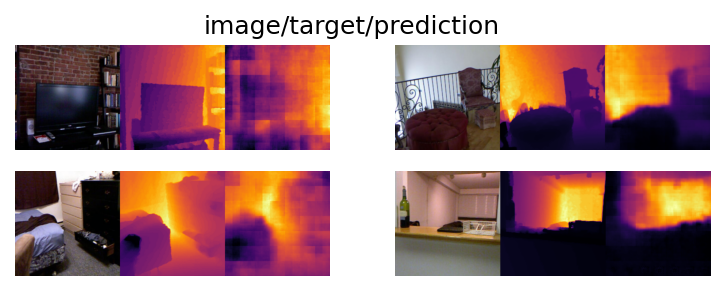

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]



  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
1   0.028987  0.021243    1.19856  1.213168  0.028989  0.021256




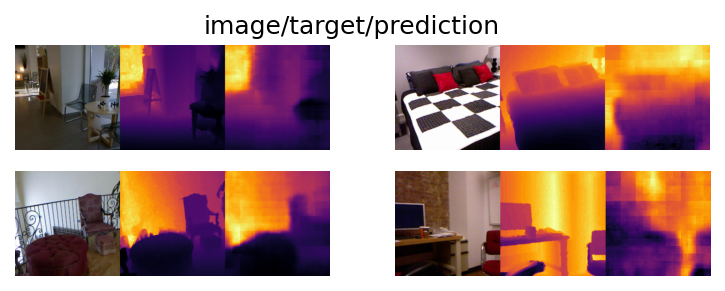

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]



  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
2   0.028514  0.021423   1.199161  1.213208  0.028516  0.021435




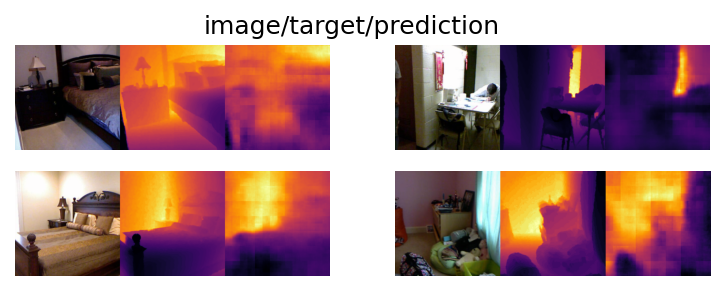

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]



  loss_train  loss_val ssim_train ssim_val mse_train   mse_val
3   0.028098  0.021231   1.199928  1.21399  0.028099  0.021244




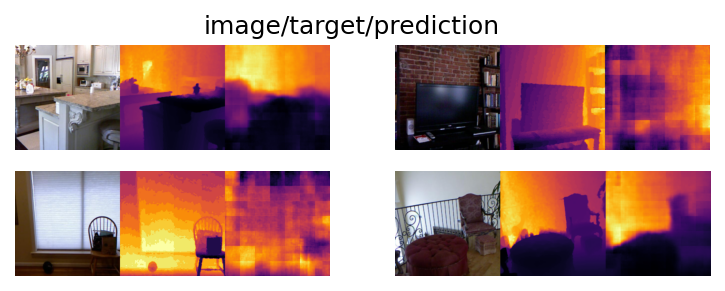

  0%|          | 0/1426 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]



  loss_train  loss_val ssim_train ssim_val mse_train   mse_val
4   0.027884  0.021576   1.199637  1.21125  0.027865  0.021589




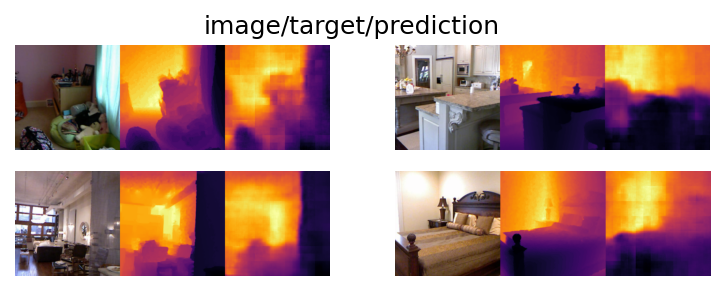

In [53]:
best_ssim = -1e9
best_epoch = -1

torch.autograd.set_detect_anomaly(True)
print('training')

for epoch in tqdm(range(epochs)):
    depthnet.train()

    accumulated_loss = 0.
    training_prog = tqdm(train_loader, total=len(train_loader))

    for rgbd, depth in training_prog:

        with autocast():
            rgbd = rgbd.to(device)
            depth = depth.to(device)

            preds = depthnet(rgbd)
            loss = loss_fn(preds, depth)

            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(depthnet.parameters(), max_norm=1.0)
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad()

            accumulated_loss += loss.item()

            training_prog.set_description(f'loss: {loss.item():.5f}')
            train_metrics(preds,depth)

        del rgbd, depth, preds, loss

    '''
    После прохождения эпохи обучения нужно измерить метрики на train и val
    '''

    train_m = train_metrics.compute()
    train_ssim = train_m['StructuralSimilarityIndexMeasure'].cpu().item()
    train_mse = train_m['MeanSquaredError'].cpu().item()

    logs.loc[epoch, ['loss_train', 'ssim_train', 'mse_train']] = (
        accumulated_loss / len(train_loader),
        train_ssim, train_mse
    )
    train_metrics.reset() #reset metrics -> None

    '''
    Проверяем модель на валидационной выборке
    '''

    depthnet.eval()

    with torch.no_grad():
        accumulated_loss = 0.
        validation_prog = tqdm(val_loader, total=len(val_loader))

        for rgbd, depth in validation_prog:

            with autocast():
                rgbd = rgbd.to(device)
                depth = depth.to(device)

                preds = depthnet(rgbd)
                loss = loss_fn(preds, depth)
                accumulated_loss += loss.item()

                validation_prog.set_description(f'loss: {loss.item():.5f}')
                val_metrics(preds, depth)

            del rgbd, depth, preds, loss

        val_m = val_metrics.compute()
        val_ssim = val_m['StructuralSimilarityIndexMeasure'].cpu().item()
        val_mse = val_m['MeanSquaredError'].cpu().item()

        logs.loc[epoch, ['loss_val', 'ssim_val', 'mse_val']] = (
            accumulated_loss / len(val_loader),
            val_ssim, val_mse
        )
        val_metrics.reset()

    '''
    Сохраняем веса модели, если нашли результат лучше предыдущего лучшего
    '''
    if val_ssim > best_ssim:
        best_ssim = val_ssim
        best_epoch = epoch
        torch.save(depthnet.state_dict(), 'depthnet_weights_1.pt')

    '''
    Выводим логи в конце эпохи
    '''

    print(f'\n\n{logs.tail(1)}\n\n')


    '''
    Визуализация работы модели на тренировачных данных
    '''
    with torch.no_grad():
        with autocast():
            rgbd, depth = next(iter(test_loader))
            rgbd = rgbd.to(device)
            depth = depth.to(device)
            preds = depthnet(rgbd)

            plot_vals(
                rgbd.cpu(),
                depth.cpu(),
                preds.cpu()
            )

    gc.collect()
    torch.cuda.empty_cache()

Сохранение чекпоинта после обучения.

In [54]:
checkpoint = {
    'logs': logs,
    'best_ssim': best_ssim,
    'best_epoch': best_epoch + 11,
    'last_lr': sched.get_last_lr(),
    'optim_state_dict': optim.state_dict()
}
torch.save(checkpoint, 'logs_third_step.pt')

# Evalute

Веса обученной модели были сохранены в файл 'depthnet_weights_best.pt'. Загрузим веса и визуализируем несколько сэмплов инференса обученной модели.

In [16]:
depthnet.load_state_dict(torch.load('depthnet_weights_best.pt', map_location=device))

<All keys matched successfully>

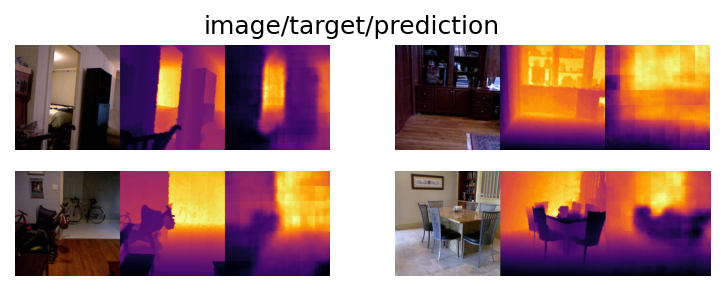

In [19]:
for rgbd, depth in test_loader:
    rgbd = rgbd.to(device)
    depth = depth.to(device)
    break

plot_vals(
    rgbd.cpu(),
    depth.cpu(),
    depthnet(rgbd).to(device).cpu()
)

## Depthnet with T > 1

Выше были продемонстированы результаты работы baseline модели. Теперь попробуем создать модель с T > 1 и посмотреть что получится.

__Примечание__: ничего хорошего. Алгоритм, созданный для улучшения инференса, ломает вывод модели в целом. Модель изначально была обучена в режиме feed-forward, т.к. в процессе обучения градиенты и соответсвующие им веса уходили в None, если инференс выводился при T > 1. В чем причина данной аномалии пока что понять не удалось.

In [20]:
encoder_adnn = Encoder(resnet_model)

adnn_layers_1 = nn.Sequential(
    ADNNConvTranspose2d(1024, 512, 4, stride=2, padding=1, activation=nn.LeakyReLU),
    ADNNConvTranspose2d(512, 256, 4, stride=2, padding=1, activation=nn.LeakyReLU)
)

adnn_1 = ADNN(adnn_layers_1, T=5)

decoder_adnn = Decoder(adnn_1)

depthnet_adnn_dict = OrderedDict()
depthnet_adnn_dict['encoder'] = encoder_adnn
depthnet_adnn_dict['decoder'] = decoder_adnn
depthnet_adnn = nn.Sequential(depthnet_adnn_dict)

depthnet_adnn = depthnet_adnn.to(device)

depthnet_adnn.load_state_dict(torch.load('depthnet_weights_best.pt', map_location=device))

<All keys matched successfully>

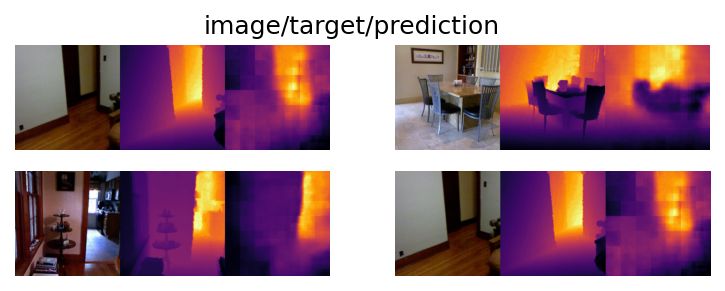

In [21]:
plot_vals(
    rgbd.cpu(),
    depth.cpu(),
    depthnet_adnn(rgbd).to(device).cpu()
)

In [34]:
test_metrics = metrics.clone()

test_results = pd.DataFrame()
test_results[['T', 'ssim_test', 'mse_test']] = None
T = [1, 2, 3, 5, 10, 20]

for i, T in enumerate(T):
    encoder_test = Encoder(resnet_model)
    adnn_layers_test = nn.Sequential(
        ADNNConvTranspose2d(1024, 512, 4, stride=2, padding=1, activation=nn.LeakyReLU),
        ADNNConvTranspose2d(512, 256, 4, stride=2, padding=1, activation=nn.LeakyReLU)
    )
    adnn_test = ADNN(adnn_layers_test, T=T)
    decoder_test = Decoder(adnn_test)

    depthnet_test_dict = OrderedDict()
    depthnet_test_dict['encoder'] = encoder_test
    depthnet_test_dict['decoder'] = decoder_test
    depthnet_test = nn.Sequential(depthnet_test_dict)

    depthnet_test = depthnet_test.to(device)
    depthnet_test.load_state_dict(torch.load('depthnet_weights_best.pt', map_location=device))

    depthnet_test.eval()
    with torch.no_grad():
            test_prog = tqdm(test_loader, total = len(test_loader))

            for rgbd, depth in test_prog:
                with autocast():
                    rgbd = rgbd.to(device)
                    depth = depth.to(device)
                    preds = depthnet_test(rgbd)
                    test_metrics(preds, depth)
                    test_prog.set_description(f'T={T}')
                del rgbd, depth, preds

            test_m = test_metrics.compute()
            test_ssim = test_m['StructuralSimilarityIndexMeasure'].cpu().item()
            test_mse = test_m['MeanSquaredError'].cpu().item()

            test_results.loc[i, ['T', 'ssim_test', 'mse_test']] = (
                T, test_ssim, test_mse
            )
            test_metrics.reset()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [35]:
test_results

,T,ssim_test,mse_test
0,1,0.934186,0.020008
1,2,0.934186,0.020008
2,3,0.934186,0.020008
3,5,0.934186,0.020008
4,10,0.934186,0.020008
5,20,0.934186,0.020008


# Results

Задача состояла в том, чтобы имплементировать подход из статьи [DeepCA via ADNN](https://openaccess.thecvf.com/content_ECCV_2018/html/Calvin_Murdock_Deep_Component_Analysis_ECCV_2018_paper.html), а также использовать его для обучения автоэнкодера для получения карты глубины по RGBD изображению (D - разреженная карта глубины) на датасете [NYUDepth V2](https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2).

В результате проделанной работы:

* Научился писать кастомные классы для работы с датасетами в PyTorch.
* Набрался практических знаний в модификации и использовании уже существующих предобученных моделей на примере ResNet50, что полезно для Transfer Learning.
* Решил проблему оптимизации скорости обучения модели (подробнее об этом ниже).
* В целом реализовал заданный подход от импорта данных в проект и до получения нужных метрик.
* Попрактиковался в использовании библиотеки PyTorch.

__Основные выводы__

Согласно представленной схеме модели на рис. 2 (см. выше), ADNN иттерации состояли из 3 слоев: две деконволюции реализующие umpasmpling, а также свертка, которая в середине работы декодера непонятно зачем сворачивает 128 карт активации в одну. Т.к. я не понял зачем эта свертка там стоит, то решил оставить только две деконовлюции. 

В классе ADNNConvTranspose2d был реализован необходимый слой с поддержкой иттерация adnn. В классе ADNN был реализован сам цикл получения инференса. В целом, в данной работе представлен частный случай использования ADNN. В общем случае можно написать целую библиотеку, которая позволяет использовать ADNN для различных линейных преобразований.

Как уже было сказано ранее, процесс обучения пришлось оптимизировать. Потому что на начальных этапах я столкнулся с тем, что одна эпоха обучения по прогнозам tqdm занимает около 10 часов (gpu на сервере google.colab). В итоге проблема была в том, что изначально было решено поместить датасет на гугл диск, чтобы в дальнейшем при каждом запуске среды заново не скачивать его и не разархивировать (что занимало много времени именно на серверах google.colab).

Далее попробовал обучить модель у себя на ноутбуке локально, но там уже была проблема в отсутствии cuda (Windows, GPU от AMD). CPU на ноутбуке показал лучший результат (2.5 часа на эпоху), но это связано уже с тем, что данные хранились непосредственно в среде, в то время как с гугл диска грузить данные в процессе обучения оказалось очень не выгодно.

В итоге, обучение нейросети было произведено на Yandex.Cloud (Yandex DataSphere). Платформа предоставляет 3000 рублей гранта на тестирование, чего мне вполне хватило чтобы обучить модель. Эпоха обучения в этом случае с учетом всех оптимизаций занимала уже не несколько часов, а 13 минут. 

Модель обучалась 15 эпох, лучший результат по метрике SSIM на валидационной выборке был показан на 14 эпохе. Обученные веса модели хранятся в файле 'depthnet_weights_best.pt'.

__Замечание:__ Во время обучения инференс из блока ADNN получался путем прямого прохода, т.к. была выявлена проблема при которой метрика loss начиная с середины первой эпохи уходит в None в случае получения инференса при T > 1. Потом оказалось, что сами градиенты уходят в None (возможно это связано с затуханием градиентов), как результат и сами веса модели превратились в None. В режиме feedforward такой проблемы выявленно не было. 

Тем более, веса модели не должны зависить от T, так как ADNN иттерации используются только на этапе получения инференса.

В результате тестирования модели для различных значений T на основе метрик MSE и SSIM, модель показала одинаковые результаты:

|  T  | ssim_test | mse_test |
|-----|-----------|----------|
|  1  | 0.934186  | 0.020008 |
|  2  | 0.934186  | 0.020008 |
|  3  | 0.934186  | 0.020008 |
|  5  | 0.934186  | 0.020008 |
| 10  | 0.934186  | 0.020008 |
| 20  | 0.934186  | 0.020008 |

T = 1 - baseline модель (работая в режиме feedforward).

С чем это может быть связано? Это может быть связано с тем, что блок ADNN вносит слишком слабый эффект в общий вывод модели (конкретно ADNN иттерации), возможно ему не хватает сложности. Также это может быть связано с предобработкой данных, в разреженной четвертого канала входных данных была на уровне 10 процентов (то есть, 10 процентов от карты глубины передавались на вход). Есть гипотеза, что 10-ти процентов feedforward модели было достаточно, чтобы в заданных условиях обучиться настолько хорошо, что ADNN иттерации не могут дать значимого эффекта для итогового вывода. Для решения этого вопроса необходимы дальнейшие исследования.

__P.S.__ Хочется добавить, для тестового это очень большое задание. Я в этом нашел много плюсов, потому что в сжатые сроки смог набрать много практических и теоретических знаний в области глубокого обучения, в частности работы с картинками. 

__P.S.S.__ В процессе изучения задачи, я наткнулся на [репозиторий](https://github.com/DeadAt0m/DCA-PyTorch.git) человека, работающего в Huawei, в котором уже имплементирован подход из статьи. Я также отдельно его тестировал с обученными заранее весами. В итоге были получены те же самые результаты, что и в таблице выше. То есть, ADNN иттерации конкретно в данном случае не дают ощутимого прироста качества на тестовом датасете в сравнении с baseline моделью.